# Basic Control Synthesis for Minigrid Environment

In [1]:
%load_ext autoreload

import gym
from IPython.display import Video

from wombats.systems import (StaticMinigridTSWrapper,
                             LavaComparison_noDryingOff)
from wombats.automaton import active_automata
from wombats.automaton import MinigridTransitionSystem

## Loading in the Specification

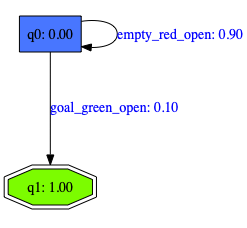

In [2]:
pdfa_config_file = 'wombats/config/PDFA_minigrid_synthesis_basic_.yaml'
pdfa_specification = active_automata.get(automaton_type='PDFA',
                                         graph_data=pdfa_config_file)
pdfa_specification.draw('basic_minigrid_pdfa')

## Loading in the Minigrid Transition System

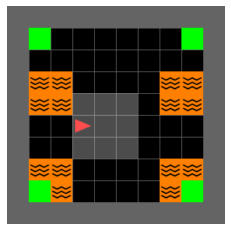

In [3]:
ENV_ID = 'MiniGrid-LavaComparison_noDryingOff-v0'
# ENV_ID = 'MiniGrid-DistShift1-v0'
# ENV_ID = 'MiniGrid-LavaGapS5-v0'
# ENV_ID = 'MiniGrid-KeyCorridorS3R1-v0'
env = gym.make(ENV_ID)

env = StaticMinigridTSWrapper(env, actions_type='default')
env.reset()
env.render_notebook()

minigrid_TS = active_automata.get(automaton_type='TS', graph_data=env,
                                  graph_data_format='minigrid')
# minigrid_TS.draw('_'.join([ENV_ID, 'TS']))

In [4]:
minigrid_TS.observations

{'empty_red_open', 'goal_green_open', 'lava_red_open'}

In [5]:
list(minigrid_TS.actions)

[<Actions.left: 0>,
 <Actions.right: 1>,
 <Actions.forward: 2>,
 <Actions.pickup: 3>,
 <Actions.drop: 4>,
 <Actions.toggle: 5>,
 <Actions.done: 6>]

## Building the Product Automaton

In [6]:
product = active_automata.get(automaton_type='Product',
                              graph_data=(minigrid_TS,
                                          pdfa_specification),
                             show_steps=False)
# product.draw('_'.join([ENV_ID, '_basic_product']))

## Computing the Most-Probable, Possible Controller

In [7]:
%autoreload 2
(controls,
 prob_of_controls_under_spec) = product.compute_strategy()

print(f'Optimal Controls: {controls}')
print(f'Probability of Generated TS Observations in Spec: ' +
      f'{prob_of_controls_under_spec}')

Optimal Controls: ['left', 'forward', 'forward', 'forward', 'forward', 'left', 'forward', 'forward']
Probability of Generated TS Observations in Spec: 0.04304672100000002


## Applying Controller to System

In [8]:
output_string, visited_states, video_path = minigrid_TS.run(controls,
                                                            record_video=True)
print(output_string)
print(visited_states)
Video(video_path, embed=True, html_attributes="controls muted autoplay loop")

['empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'goal_green_open']
['(3, 5), right', '(3, 5), up', '(3, 4), up', '(3, 3), up', '(3, 2), up', '(3, 1), up', '(3, 1), left', '(2, 1), left', '(1, 1), left']
